## CSML1010 Group3 Course_Project - Milestone 1 - Feature Engineering and Selection
#### Authors: Paul Doucet, Jerry Khidaroo

#### Import Libraries

In [1]:
# import pandas, numpy
import pandas as pd
import numpy as np
import re
import nltk


#### Set Some Defaults

In [2]:
# adjust pandas display
pd.options.display.max_columns = 30
pd.options.display.max_rows = 100
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.precision = 2
pd.options.display.max_colwidth = None

# Import matplotlib and seaborn and adjust some defaults
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100

import seaborn as sns
sns.set_style("whitegrid")

#### Load Data

In [3]:
import sqlite3

sql = """
SELECT p.*
FROM posts_nlp p
"""

with sqlite3.connect('selfdialogs.db') as con:
    df = pd.read_sql_query(sql, con)

#### Get relevant columns

In [4]:
sql = """
SELECT p.selfdialog_clean, p.instruction_id
FROM posts_nlp p
"""

with sqlite3.connect('selfdialogs.db') as con:
    df_all = pd.read_sql_query(sql, con)

Down sample to 1000 records.

In [5]:
print ((1000 * 1000)//7708)

129


In [6]:
# Get 50 per instruction_id then reduce to 1000
def sampling_k_elements(group, k=130):
    if len(group) < k:
        return group
    return group.sample(k)

#Get balanced samples
corpus_df = df_all.groupby('Instruction_id').apply(sampling_k_elements).reset_index(drop=True)

#Reduce to 1000
corpus_df = corpus_df.sample(n=1000, random_state=1)
print (corpus_df.groupby('Instruction_id').size())

Instruction_id
auto-repair-appt-1    78
coffee-ordering-1     73
coffee-ordering-2     79
movie-finder          36
movie-tickets-1       80
movie-tickets-2       79
movie-tickets-3       76
pizza-ordering-1      70
pizza-ordering-2      81
restaurant-table-1    72
restaurant-table-2    73
restaurant-table-3    65
uber-lyft-1           71
uber-lyft-2           67
dtype: int64


#### Create Factorized 'category' column from 'Instruction_id' label column.

In [7]:
corpus_df['category'] = corpus_df['Instruction_id'].factorize()[0]
corpus_df.head(5)

,selfdialog_clean,Instruction_id,category
111,"Hi, this is Jamie Doe. My car is having problems. It needs to be looked at. Sorry to hear that. What is wrong with it? Fluid is leaking. It started today. Where do you want to go for the repair? I like Intelligent Auto Solutions. Okay, sure. How does 8 am tomorrow morning sound? I would really like to bring it in sooner. This issue worries me. Okay, does 7 pm this evening sound better? Yes, definitely. Okay, please give me your contact number to use for them. 555-666-7777. And the make, model and year of the vehicle. Volvo C30 2010 Okay, to reiterate: Jamie Doe, 555-666-7777, Volvo C30 2010. That is correct. You're appointment is set. 7 pm tonight. Thank you so much. No problem. Also, the fee for inspection is $140. Tnanks. Bye now. Bye bye.",auto-repair-appt-1,0
126,"Hi, I need to make an appointment to have my car looked at Alright, what's the year, make and model of your car? It's a 2009 Chevy Corvette Ok, and what kind of problem is it having? I think the clutch is slipping That doesn't sound good, do you have a mechanic that you prefer? Yes, I always go to Intelligent Auto Solutions Alright, that's Intelligent Auto Solutions on the corner of Fowler and New Castle Road in Birmingham? Yep, that's the one Are you looking for a morning or afternoon appointment? Mornings are best, as early as possible so I can drop my car off before work Alright, It looks like they have an opening on Thursday at 7am Ouch, that's three days away, I don't think it's going to make it that long, I really need it looked at sooner, is there anything for Tuesday or Wednesday? They have an afternoon appointment available on Wednesday at 1pm, or a late 4pm appointment tomorrow Go ahead and get me the one for 4pm tomorrow, at least they can look at it and give me an estimate then Ok great, what name and phone number should I make the appointment under? Jon Smith, 4242058890 Ok, just to confirm I have you down for a 4pm appointment tomorrow with Intelligent Auto Solutions to look at your Corvette about a problem with the clutch, is that correct? Yes And lastly, it says here there is a $150 fee for the initial inspection which is waived if you have the repair done at their shop I'm aware of that, I've gone there before Ok great, is there anything else I can help with? No that's all, thank you You're welcome, have a great day",auto-repair-appt-1,0
555,"I'd like to order tickets to the Lego Movie 2. Great, which theatre would you like to attend? We have 5 people who'd like to attend at the at Regal Manor Stadium 16 in Lancaster,PA. Would you like to see the movie in 3-D? No thank you, just 2D. Okay, when would you like to attend the movies? We're looking at this evening. What times are available? We have an 8PM and 10PM show. We'd like the 10 PM show please. Would you like to add on a snack package option for an additional $10? No thanks, just the movie. Okay, how many adults and how many children? There will be 2 adults and 3 children. How much is that? It is $7.50 for adults and $6.00 for children for a total of $33.00. I'd like to charge that to my movie credit account. Great, we'll take care of that for you. Thank you. Okay, so your tickets are being sent to your mobile device via text message. Thanks! That is great. I hope you enjoy your Lego Movie 2 tonight at 10PM at Regal Manor Stadium 16 in Lancaster,PA.",movie-tickets-1,1
1260,"I'm interested in a steakhouse or just American cuisine What is your location? I'm in the Houston, Texas area When would you like to go out? I'd like dinner around 6:30pm How many people will be in your party? Two Do you have any seating preferences? I'd like an outdoor seat with a wine menu Ok Can Taste of Texas accommodate me? Unfortunately, there is no seating available then Ok, do they have a wine menu? No, they do not have a wine menu Alright, is there a restaurant in the city that would match my criteria? Houston's should work Ok, let's go with that So to confirm, you wan

#### Word Embeddings

In [8]:
df.columns

Index(['index', 'id', 'Conversation', 'Instruction_id', 'service_type',
       'selfdialog_clean', 'selfdialog_lemma', 'selfdialog_nouns',
       'selfdialog_adjectives', 'selfdialog_verbs', 'selfdialog_nav',
       'no_tokens'],
      dtype='object')

In [9]:
corpus_df.columns

Index(['selfdialog_clean', 'Instruction_id', 'category'], dtype='object')

#### Do Some Additional CLeaning

In [10]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    #doc = "'" + doc + "'"
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    #doc = [[word.lower() for word in sent if word not in remove_terms] for sent in doc]
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    
    return doc

normalize_corpus = np.vectorize(normalize_document)

In [12]:
for i, row in corpus_df.iterrows():
    corpus_df.at[i, "selfdialog_norm"] = normalize_corpus(row.selfdialog_clean) 

corpus_df.head(3)

,selfdialog_clean,Instruction_id,category,selfdialog_norm
111,"Hi, this is Jamie Doe. My car is having problems. It needs to be looked at. Sorry to hear that. What is wrong with it? Fluid is leaking. It started today. Where do you want to go for the repair? I like Intelligent Auto Solutions. Okay, sure. How does 8 am tomorrow morning sound? I would really like to bring it in sooner. This issue worries me. Okay, does 7 pm this evening sound better? Yes, definitely. Okay, please give me your contact number to use for them. 555-666-7777. And the make, model and year of the vehicle. Volvo C30 2010 Okay, to reiterate: Jamie Doe, 555-666-7777, Volvo C30 2010. That is correct. You're appointment is set. 7 pm tonight. Thank you so much. No problem. Also, the fee for inspection is $140. Tnanks. Bye now. Bye bye.",auto-repair-appt-1,0,hi jamie doe car problems needs looked sorry hear wrong fluid leaking started today want go repair like intelligent auto solutions okay sure tomorrow morning sound would really like bring sooner issue worries okay pm evening sound better yes definitely okay please give contact number use make model year vehicle volvo c okay reiterate jamie doe volvo c correct youre appointment set pm tonight thank much problem also fee inspection tnanks bye bye bye
126,"Hi, I need to make an appointment to have my car looked at Alright, what's the year, make and model of your car? It's a 2009 Chevy Corvette Ok, and what kind of problem is it having? I think the clutch is slipping That doesn't sound good, do you have a mechanic that you prefer? Yes, I always go to Intelligent Auto Solutions Alright, that's Intelligent Auto Solutions on the corner of Fowler and New Castle Road in Birmingham? Yep, that's the one Are you looking for a morning or afternoon appointment? Mornings are best, as early as possible so I can drop my car off before work Alright, It looks like they have an opening on Thursday at 7am Ouch, that's three days away, I don't think it's going to make it that long, I really need it looked at sooner, is there anything for Tuesday or Wednesday? They have an afternoon appointment available on Wednesday at 1pm, or a late 4pm appointment tomorrow Go ahead and get me the one for 4pm tomorrow, at least they can look at it and give me an estimate then Ok great, what name and phone number should I make the appointment under? Jon Smith, 4242058890 Ok, just to confirm I have you down for a 4pm appointment tomorrow with Intelligent Auto Solutions to look at your Corvette about a problem with the clutch, is that correct? Yes And lastly, it says here there is a $150 fee for the initial inspection which is waived if you have the repair done at their shop I'm aware of that, I've gone there before Ok great, is there anything else I can help with? No that's all, thank you You're welcome, have a great day",auto-repair-appt-1,0,hi need make appointment car looked alright whats year make model car chevy corvette ok kind problem think clutch slipping doesnt sound good mechanic prefer yes always go intelligent auto solutions alright thats intelligent auto solutions corner fowler new castle road birmingham yep thats one looking morning afternoon appointment mornings best early possible drop car work alright looks like opening thursday ouch thats three days away dont think going make long really need looked sooner anything tuesday wednesday afternoon appointment available wednesday pm late pm appointment tomorrow go ahead get one pm tomorrow least look give estimate ok great name phone number make appointment jon smith ok confirm pm appointment tomorrow intelligent auto solutions look corvette problem clutch correct yes lastly says fee initial inspection waived repair done shop im aware ive gone ok great anything else help thats thank youre welcome great day
555,"I'd like to order tickets to the Lego Movie 2. Great, which theatre would you like to attend? We have 5 people who'd like to attend at the at Regal Manor Stadium 16 in Lancast

In [13]:
doc_lst = []
for i, row in corpus_df.iterrows():
    doc_lst.append(row.selfdialog_norm.tolist())

print(len(doc_lst))
doc_lst[1:5]

1000


['hi need make appointment car looked alright whats year make model car chevy corvette ok kind problem think clutch slipping doesnt sound good mechanic prefer yes always go intelligent auto solutions alright thats intelligent auto solutions corner fowler new castle road birmingham yep thats one looking morning afternoon appointment mornings best early possible drop car work alright looks like opening thursday ouch thats three days away dont think going make long really need looked sooner anything tuesday wednesday afternoon appointment available wednesday pm late pm appointment tomorrow go ahead get one pm tomorrow least look give estimate ok great name phone number make appointment jon smith ok confirm pm appointment tomorrow intelligent auto solutions look corvette problem clutch correct yes lastly says fee initial inspection waived repair done shop im aware ive gone ok great anything else help thats thank youre welcome great day',
 'id like order tickets lego movie great theatre wou

#### Build Vocabulary

In [14]:
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence

tokenizer = text.Tokenizer(lower=False)
tokenizer.fit_on_texts(doc_lst)
word2id = tokenizer.word_index

word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in doc_lst]

vocab_size = len(word2id)
embed_size = 100
window_size = 2

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Using TensorFlow backend.
Vocabulary Size: 5868
Vocabulary Sample: [('like', 1), ('would', 2), ('okay', 3), ('ok', 4), ('yes', 5), ('pm', 6), ('want', 7), ('order', 8), ('tickets', 9), ('thank', 10)]


#### Build (context_words, target_word) pair generator

In [15]:
def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size*2
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            label_word.append(word)

            x = sequence.pad_sequences(context_words, maxlen=context_length)
            y = np_utils.to_categorical(label_word, vocab_size)
            yield (x, y)

In [16]:
i = 0
for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])
    
        if i == 10:
            break
        i += 1

Context (X): ['hi', 'jamie', 'car', 'problems'] -> Target (Y): doe
Context (X): ['jamie', 'doe', 'problems', 'needs'] -> Target (Y): car
Context (X): ['doe', 'car', 'needs', 'looked'] -> Target (Y): problems
Context (X): ['car', 'problems', 'looked', 'sorry'] -> Target (Y): needs
Context (X): ['problems', 'needs', 'sorry', 'hear'] -> Target (Y): looked
Context (X): ['needs', 'looked', 'hear', 'wrong'] -> Target (Y): sorry
Context (X): ['looked', 'sorry', 'wrong', 'fluid'] -> Target (Y): hear
Context (X): ['sorry', 'hear', 'fluid', 'leaking'] -> Target (Y): wrong
Context (X): ['hear', 'wrong', 'leaking', 'started'] -> Target (Y): fluid
Context (X): ['wrong', 'fluid', 'started', 'today'] -> Target (Y): leaking
Context (X): ['fluid', 'leaking', 'today', 'want'] -> Target (Y): started


#### Set up Dictionaries to Cross-Refrence 'Instruction_id' and its Factorized value 'category'

In [17]:
category_id_df = corpus_df[['Instruction_id', 'category']].drop_duplicates().sort_values('category')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category', 'Instruction_id']].values)

#### Split Data into Train and Test Sets

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(doc_lst, corpus_df['Instruction_id'], test_size=0.25, random_state = 0)

#### Bag of Words Feature Extraction

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=0., max_df=1., vocabulary=word2id)
cv_matrix = cv.fit_transform(doc_lst)
cv_matrix = cv_matrix.toarray()
cv_matrix

array([[0, 2, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 8, 4, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 2, 0, ..., 0, 0, 0],
       [0, 6, 5, ..., 0, 1, 1]], dtype=int64)

In [20]:
# get all unique words in the corpus
vocab = cv.get_feature_names()
# show document feature vectors
pd.DataFrame(cv_matrix, columns=vocab)

,PAD,like,would,okay,ok,yes,pm,want,order,tickets,thank,please,time,one,great,...,nodumb,dumber,geniusyou,enabled,rising,owe,substituting,mezzana,sorinella,glyndon,whyare,babel,arrivng,anyhow,mention
0,0,2,1,4,0,1,2,1,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,4,2,4,0,0,0,1,0,0,2,3,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,8,4,3,0,0,4,0,1,2,2,1,0,0,3,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,3,2,0,3,0,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,2,0,2,0,0,0,2,1,0,0,0,0,7,3,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,9,4,0,3,2,0,0,7,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
996,0,2,4,0,3,0,3,0,0,0,1,2,2,0,0,...,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
997,0,0,0,4,0,1,0,2,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0
998,0,2,0,0,1,1,7,0,0,7,3,2,2,1,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Bag of Words Feature Benchmarking with Naive Bayes Classifier

In [21]:
X_train_bow = cv.fit_transform(X_train).toarray()
X_test_bow = cv.transform(X_test).toarray()
print (X_train_bow.shape) 
print (X_test_bow.shape) 
print (y_test.shape)

(750, 5868)
(250, 5868)
(250,)


In [23]:
from sklearn.naive_bayes import MultinomialNB

naive = MultinomialNB()
classifier = naive.fit(X_train_bow, y_train)
predict_bow = classifier.predict(X_test_bow)

In [24]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(predict_bow,y_test)
cm

array([[18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  9,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 10, 11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  9,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1, 17,  2,  3,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  3, 19,  9,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  1, 12,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  7,  5,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  7, 18,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 13,  2,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  7, 14, 10,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  1,  6,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 13,  6],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  7]],
      dtype=int64)

In [25]:
accuracy = cm.trace()/cm.sum()
print(accuracy)

0.692


In [26]:
from sklearn import metrics
print(metrics.classification_report(y_test, predict_bow, target_names=corpus_df['Instruction_id'].unique()))

precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        18
   movie-tickets-1       0.64      0.47      0.55        19
restaurant-table-2       0.52      0.69      0.59        16
  pizza-ordering-1       1.00      0.82      0.90        11
restaurant-table-1       0.74      0.85      0.79        20
restaurant-table-3       0.61      0.86      0.72        22
 coffee-ordering-2       0.86      0.50      0.63        24
       uber-lyft-1       0.58      0.50      0.54        14
   movie-tickets-2       0.72      0.78      0.75        23
 coffee-ordering-1       0.87      0.59      0.70        22
       uber-lyft-2       0.45      0.82      0.58        17
   movie-tickets-3       0.67      0.38      0.48        16
  pizza-ordering-2       0.68      0.87      0.76        15
      movie-finder       0.78      0.54      0.64        13

          accuracy                           0.69       250
         macro avg       0.72      0.69      0.69       25

#### Feature Selection Using Chi-Squared Method

In [27]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

num_feats = 2000
X_norm = MinMaxScaler().fit_transform(X_train_bow, y_train)
chi_selector = SelectKBest(chi2, k=num_feats)
chi_selector.fit(X_norm, y_train)
chi_support = chi_selector.get_support()
#chi_feature = X_train[:,chi_support.columns.tolist()
X_train_bow_chi = X_train_bow[:,chi_support]
X_test_bow_chi = X_test_bow[:,chi_support]
#print(str(len(X_train_bow_chi)), 'selected features')
print(X_train_bow_chi.shape)

(750, 2000)


Re-Run on Smaller Feature set

In [28]:
classifier_chi = naive.fit(X_train_bow_chi, y_train)
predict_bow_chi = classifier_chi.predict(X_test_bow_chi)

In [29]:
cm_chi = confusion_matrix(predict_bow_chi,y_test)
cm_chi

array([[18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 11,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  8, 11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1, 19,  1,  4,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1, 20,  9,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1, 11,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  6,  6,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  8, 17,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 10,  2,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  8, 13, 10,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  2,  6,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  9,  2],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  6, 11]],
      dtype=int64)

In [30]:
accuracy_chi = cm_chi.trace()/cm_chi.sum()
print(accuracy_chi)

0.688


In [31]:
print(metrics.classification_report(y_test, predict_bow_chi, target_names=corpus_df['Instruction_id'].unique()))

precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        18
   movie-tickets-1       0.69      0.58      0.63        19
restaurant-table-2       0.58      0.69      0.63        16
  pizza-ordering-1       1.00      0.91      0.95        11
restaurant-table-1       0.76      0.95      0.84        20
restaurant-table-3       0.67      0.91      0.77        22
 coffee-ordering-2       0.92      0.46      0.61        24
       uber-lyft-1       0.50      0.43      0.46        14
   movie-tickets-2       0.68      0.74      0.71        23
 coffee-ordering-1       0.83      0.45      0.59        22
       uber-lyft-2       0.42      0.76      0.54        17
   movie-tickets-3       0.50      0.38      0.43        16
  pizza-ordering-2       0.82      0.60      0.69        15
      movie-finder       0.65      0.85      0.73        13

          accuracy                           0.69       250
         macro avg       0.71      0.69      0.68       25

#### TF-IDF Feature Extraction

In [32]:
#from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_test_counts = count_vect.transform(X_test)
#vocab_tfidf = count_vect.vocabulary_
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(750, 5065)
(250, 5065)


#### Train TF-IDF Model with Naive Bayes Classifier: Multinomial variant

In [33]:
clf = MultinomialNB().fit(X_train_tfidf, y_train)

#### Make Some Predictions

In [34]:
X_new_data_counts = count_vect.transform(["appointment online car checking bmw okay hold minute problem okay entered thank need bring need alignment"])
X_new_data_tfidf = tfidf_transformer.fit_transform(X_new_data_counts)
print(X_new_data_tfidf.shape)
y_pred_new = clf.predict(X_new_data_tfidf)
y_pred_new

(1, 5065)


array(['auto-repair-appt-1'], dtype='<U18')

#### TF-IDF Benchmarking with Naive Bayes Classifier: Multinomial variant

In [35]:
from sklearn.metrics import confusion_matrix

y_pred_tfidf = clf.predict(X_test_tfidf)
cm_nb_tfidf = confusion_matrix(y_pred_tfidf,y_test)
cm_nb_tfidf

array([[18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 19, 16,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  2, 19,  4,  3,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  2,  1, 17,  6,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  7,  0,  1, 15,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  3,  3,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 11, 20,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 19, 15, 14,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  2,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 12,  4],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  9]],
      dtype=int64)

In [36]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred_tfidf, target_names=corpus_df['Instruction_id'].unique()))

precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        18
   movie-tickets-1       0.00      0.00      0.00        19
restaurant-table-2       0.46      1.00      0.63        16
  pizza-ordering-1       0.00      0.00      0.00        11
restaurant-table-1       0.68      0.95      0.79        20
restaurant-table-3       0.65      0.77      0.71        22
 coffee-ordering-2       0.65      0.62      0.64        24
       uber-lyft-1       0.50      0.21      0.30        14
   movie-tickets-2       0.65      0.87      0.74        23
 coffee-ordering-1       0.67      0.09      0.16        22
       uber-lyft-2       0.31      0.88      0.46        17
   movie-tickets-3       0.50      0.12      0.20        16
  pizza-ordering-2       0.75      0.80      0.77        15
      movie-finder       0.75      0.69      0.72        13

          accuracy                           0.59       250
         macro avg       0.54      0.57      0.51       25

#### TF-IDF Benchmarking with LinearSVC

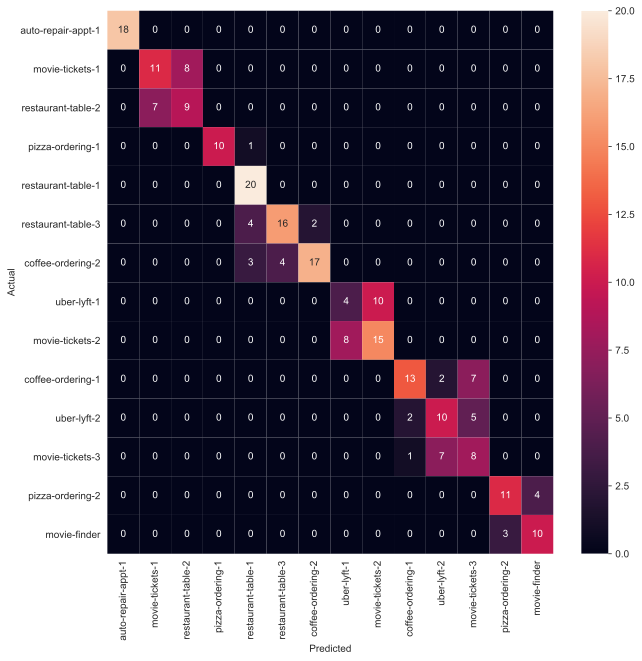

In [38]:
from sklearn.svm import LinearSVC

model = LinearSVC()
model.fit(X_train_tfidf, y_train)
y_pred_svc = model.predict(X_test_tfidf)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred_svc)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Instruction_id.values, yticklabels=category_id_df.Instruction_id.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### Metrics For Each Class

In [39]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred_svc, target_names=corpus_df['Instruction_id'].unique()))

precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        18
   movie-tickets-1       0.61      0.58      0.59        19
restaurant-table-2       0.53      0.56      0.55        16
  pizza-ordering-1       1.00      0.91      0.95        11
restaurant-table-1       0.71      1.00      0.83        20
restaurant-table-3       0.80      0.73      0.76        22
 coffee-ordering-2       0.89      0.71      0.79        24
       uber-lyft-1       0.33      0.29      0.31        14
   movie-tickets-2       0.60      0.65      0.63        23
 coffee-ordering-1       0.81      0.59      0.68        22
       uber-lyft-2       0.53      0.59      0.56        17
   movie-tickets-3       0.40      0.50      0.44        16
  pizza-ordering-2       0.79      0.73      0.76        15
      movie-finder       0.71      0.77      0.74        13

          accuracy                           0.69       250
         macro avg       0.69      0.69      0.69       25

#### Word2Vec Feature Extraction

In [40]:
from gensim.models import word2vec

# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in X_train]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 30          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                          window=window_context, min_count=min_word_count,
                          sample=sample, iter=50)

# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['rental', 'pizza', 'terminator', 'star', 'audi', 'east', 'korean','playing']}
similar_words

{'rental': ['clutch', 'contected', 'dealership', 'rain', 'covered'],
 'pizza': ['sausage', 'hut', 'toppings', 'zucchini', 'xlarge'],
 'terminator': ['judgment', 'abyss', 'avatar', 'sigourney', 'vi'],
 'star': ['highest', 'wars', 'rating', 'country', 'starship'],
 'audi': ['fletcher', 'shift', 'constantly', 'steering', 'accessed'],
 'east': ['denver', 'seasons', 'centre', 'greensboro', 'chicago'],
 'korean': ['bbq', 'bbgo', 'lauderhill', 'kansas', 'honey'],
 'playing': ['movie', 'dumbo', 'support', 'central', 'apollo']}

#### Visualizing word embeddings

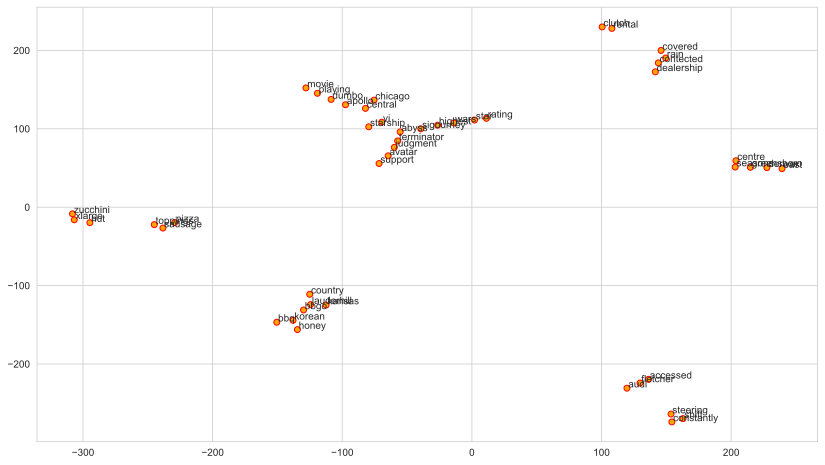

In [41]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

#### Applying the word2vec model on our Train dataset

In [42]:
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in X_train]
tokenized_corpus_test = [wpt.tokenize(document) for document in X_test]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 10          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                              window=window_context, min_count = min_word_count,
                              sample=sample, iter=100)

In [43]:
w2v_model.wv['jedi']

array([-0.12386877, -0.18022077,  0.13629217, -0.19519687,  0.3317206 ,
        0.00069295,  0.24395373, -0.3781109 ,  0.06554157,  0.42532593,
        0.20056772,  0.09119608, -0.15625575,  0.4736171 , -0.7117875 ,
        0.10899312,  0.00242457, -0.45726466,  0.10529283, -0.25862002,
       -0.42094752,  0.5121968 , -0.05237279, -0.90652514, -0.14884688,
        0.42004946,  0.06401213, -0.3180457 , -0.41755238, -0.461846  ,
        0.20633754,  0.16488461,  0.38565844,  0.23672952,  0.04432544,
       -0.14952208, -0.77574533,  0.4833171 ,  0.00396687, -0.12313127,
       -0.45220608,  0.2631155 , -0.13137814, -0.6397368 ,  0.14818981,
        0.3318139 ,  0.06218205,  0.7651859 ,  0.2695103 , -0.49214005,
       -0.8230682 ,  0.71564895,  0.1005525 ,  0.2685369 , -0.4538102 ,
        0.222405  , -0.07698992,  0.7197483 ,  0.01907734, -0.1331166 ,
       -0.61503625,  0.38384575, -0.45135337,  0.18665229,  0.04427072,
       -0.03228565,  0.35671657,  0.37524447,  0.5474545 ,  0.37

#### Build framework for getting document level embeddings

In [44]:
def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector
    
   
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [45]:
w2v_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, model=w2v_model,
                                             num_features=feature_size)
pd.DataFrame(w2v_feature_array)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,0.26,0.42,0.06,-0.33,0.65,0.01,-0.23,-0.17,0.02,0.16,-0.75,1.03,0.92,-0.91,0.11,...,-0.70,-0.10,-0.74,0.01,0.79,-0.65,0.51,-0.09,0.37,-0.10,-0.13,-0.18,0.31,-0.90,0.14
1,-0.68,0.99,-0.92,-0.82,-0.55,0.24,-0.08,0.46,-0.10,-0.42,-0.50,-0.48,-0.50,0.42,-0.31,...,0.49,-0.97,0.23,0.56,-0.38,0.22,-0.46,-0.95,-0.76,-0.75,-0.46,0.07,0.40,-0.02,-0.42
2,-0.39,0.02,-1.15,-0.53,-0.08,0.24,-0.09,0.40,0.03,-0.83,0.16,0.45,0.41,0.24,-0.78,...,-0.44,-0.09,-0.15,-0.24,-0.09,-0.92,-0.42,-0.06,0.09,-0.88,-0.23,0.08,0.79,-0.11,0.49
3,0.27,-0.01,-0.67,-0.04,0.06,-0.86,0.96,-0.52,-0.15,-0.33,0.18,1.00,1.37,0.07,-1.20,...,-0.12,0.88,-0.41,0.29,-0.39,0.07,-0.57,-0.54,-0.41,-1.33,-0.03,-0.36,0.83,-0.93,0.50
4,0.09,-0.34,-0.31,0.01,0.04,-1.09,0.97,0.17,-0.51,-0.25,-0.02,0.91,0.78,0.04,-1.67,...,0.18,1.13,-0.40,-0.66,0.23,-0.38,0.33,-0.04,-0.32,-1.44,0.14,-0.51,0.73,-0.41,-0.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,-0.67,0.03,-1.25,-0.45,0.31,0.22,0.35,-0.57,-0.18,-0.40,0.29,-0.24,0.42,0.46,-1.16,...,-0.76,-0.20,0.11,-0.14,-0.20,-0.37,-0.31,-0.36,0.48,-0.39,-0.02,0.63,1.26,-0.30,0.54
746,-0.25,-0.28,-1.35,0.09,0.35,1.12,0.02,-0.18,0.18,-0.22,0.26,-0.18,-0.57,-0.34,-0.42,...,-0.76,-0.43,0.45,0.85,-0.31,0.91,-0.32,-1.04,-0.37,-0.24,0.09,0.35,0.53,-0.11,-0.39
747,-0.60,0.32,-1.34,-0.35,-0.43,0.31,-0.04,0.15,0.39,-0.63,0.23,-0.33,0.16,0.35,-0.66,...,-0.60,-0.91,0.26,0.11,-0.25,-0.25,-0.25,-0.56,-0.00,-0.33,-0.08,0.64,1.27,0.00,1.05
748,-0.63,-0.00,-0.73,-0.24,-0.07,0.26,0.23,0.14,-0.45,-0.12,-0.27,0.84,1.01,-0.04,-0.66,...,-0.63,-0.40,-0.37,-0.01,-0.43,0.31,-0.11,-0.69,0.01,-0.55,0.48,0.30,0.78,-1.33,0.27


In [46]:
w2v_test_array = averaged_word_vectorizer(corpus=tokenized_corpus_test, model=w2v_model,
                                             num_features=feature_size)
                                             
print(w2v_test_array.shape)

(250, 100)


#### Word2vec Feature Benchmarking with LinearSVC Classifier

In [47]:
from sklearn.svm import LinearSVC

model_w2v = LinearSVC()
classifier = model_w2v.fit(w2v_feature_array, y_train)
predict_w2v = classifier.predict(w2v_test_array)

In [48]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(predict_w2v,y_test)
cm

array([[18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 14,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  5, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  9,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 15,  1,  2,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  5, 18,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  2, 21,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  8,  9,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  6, 14,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  0, 11,  1,  2,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  8, 11,  8,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  5,  6,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0, 11,  2],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3, 11]],
      dtype=int64)

In [49]:
from sklearn import metrics
print(metrics.classification_report(y_test, predict_w2v, target_names=corpus_df['Instruction_id'].unique()))

precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        18
   movie-tickets-1       0.70      0.74      0.72        19
restaurant-table-2       0.67      0.62      0.65        16
  pizza-ordering-1       0.90      0.82      0.86        11
restaurant-table-1       0.83      0.75      0.79        20
restaurant-table-3       0.75      0.82      0.78        22
 coffee-ordering-2       0.91      0.88      0.89        24
       uber-lyft-1       0.44      0.57      0.50        14
   movie-tickets-2       0.70      0.61      0.65        23
 coffee-ordering-1       0.73      0.50      0.59        22
       uber-lyft-2       0.41      0.65      0.50        17
   movie-tickets-3       0.43      0.38      0.40        16
  pizza-ordering-2       0.79      0.73      0.76        15
      movie-finder       0.79      0.85      0.81        13

          accuracy                           0.71       250
         macro avg       0.72      0.71      0.71       25

## Additional Advanced Methods To Explore Further

#### GloVe Embeddings with spaCy

In [50]:
import spacy

nlp = spacy.load('en_vectors_web_lg')

total_vectors = len(nlp.vocab.vectors)
print('Total word vectors:', total_vectors)

Total word vectors: 1070971


#### Visualize GloVe word embeddings

In [51]:
unique_words = list(set([word for sublist in [doc.split() for doc in X_train] for word in sublist]))
word_glove_vectors = np.array([nlp(word).vector for word in unique_words])

pd.DataFrame(word_glove_vectors, index=unique_words)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
continental,0.24,0.05,0.88,-0.08,0.66,-0.10,-0.02,0.64,-0.50,1.30,-0.57,-0.15,-0.41,0.60,0.66,...,0.55,-0.01,0.16,0.03,0.27,-0.10,0.62,-0.12,-0.47,0.40,0.03,0.71,0.03,-0.62,-0.05
rows,0.69,0.09,-0.64,-0.02,0.52,0.12,-0.11,0.40,-0.30,0.30,0.29,0.23,0.12,-0.04,0.11,...,-0.10,-0.01,0.09,0.26,-0.29,0.24,0.23,-0.02,-0.27,-0.68,0.10,-0.30,0.04,0.48,0.08
wines,-0.87,0.02,0.36,-1.26,1.01,0.39,0.53,0.43,-0.38,1.68,-0.11,0.82,-0.51,-0.54,0.32,...,0.73,0.52,0.34,-0.04,0.80,0.32,0.92,-0.71,0.18,-0.42,-0.88,0.55,-0.68,1.03,-0.19
artists,0.05,-0.34,0.20,-0.16,-0.02,-0.05,0.03,0.22,-0.28,2.49,0.31,-0.05,-0.20,-0.20,0.53,...,0.26,0.52,0.14,-0.09,0.03,-0.74,-0.19,0.08,0.51,-0.16,-0.21,0.18,-0.04,0.13,0.49
rebel,0.08,-0.30,0.33,-0.03,0.32,-0.48,-0.80,0.60,-0.06,1.54,-0.11,-0.34,-0.65,-0.45,-0.06,...,-0.08,0.21,0.52,0.09,0.05,-0.59,0.21,-0.01,-0.39,-0.21,0.26,0.13,0.42,-0.11,-0.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pads,0.50,0.44,-0.43,-0.02,-0.11,0.16,0.04,-0.17,0.03,0.07,0.61,0.25,0.15,0.29,-0.26,...,-0.61,-0.51,-0.32,-0.44,-0.55,-0.09,0.04,0.45,-0.25,-0.22,-0.07,0.41,0.12,0.71,-0.29
title,-0.27,-0.11,-0.44,0.06,0.07,-0.09,-0.02,-0.22,0.02,1.84,-0.50,0.73,0.39,-0.01,0.49,...,-0.06,-0.26,0.32,0.26,-0.56,0.21,-0.47,-0.39,-0.18,0.51,0.08,-0.25,-0.66,0.30,-0.37
closest,0.52,-0.47,-0.28,0.34,0.92,-0.35,-0.12,0.58,0.24,2.27,-0.05,0.34,0.04,-0.11,0.18,...,-0.05,-0.43,-0.35,-0.19,0.16,0.11,0.07,-0.10,0.42,0.28,0.10,0.01,-0.32,-0.10,0.55
dixon,-0.22,1.19,-0.16,-0.57,0.35,-0.57,0.02,-0.21,-0.03,-0.36,0.31,-0.31,0.39,-0.45,-0.37,...,-0.02,0.08,-0.08,-0.02,-0.37,0.29,0.27,0.24,-0.26,0.25,-0.20,0.37,0.05,-0.44,-0.02


In [52]:
unique_words_test = list(set([word for sublist in [doc.split() for doc in X_test] for word in sublist]))
word_glove_vectors_test = np.array([nlp(word).vector for word in unique_words])
print(word_glove_vectors_test.shape)

(5091, 300)


#### Word2vec features with Fastext Model

In [53]:
from gensim.models.fasttext import FastText

wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in X_train]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 50          # Context window size                                                                                    
min_word_count = 5   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words


ft_model = FastText(tokenized_corpus, size=feature_size, window=window_context, 
                    min_count=min_word_count,sample=sample, sg=1, iter=50)

In [54]:
# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in ft_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['rental', 'pizza', 'terminator', 'star', 'audi', 'east', 'korean','playing']}
similar_words

{'rental': ['dinner', 'capital', 'food', 'thinking', 'eat'],
 'pizza': ['pepperoni', 'cheese', 'crust', 'sausage', 'large'],
 'terminator': ['nevermind',
  'terrific',
  'event',
  'unfortunately',
  'confirming'],
 'star': ['wars', 'born', 'oct', 'fresno', 'rating'],
 'audi': ['weird', 'wrong', 'model', 'jones', 'appointment'],
 'east': ['requested', 'atlanta', 'chicago', 'suppose', 'places'],
 'korean': ['bbq', 'pig', 'accommodate', 'requests', 'alex'],
 'playing': ['movie', 'showing', 'tickets', 'show', 'theater']}

#### PCA on Fasttext Model

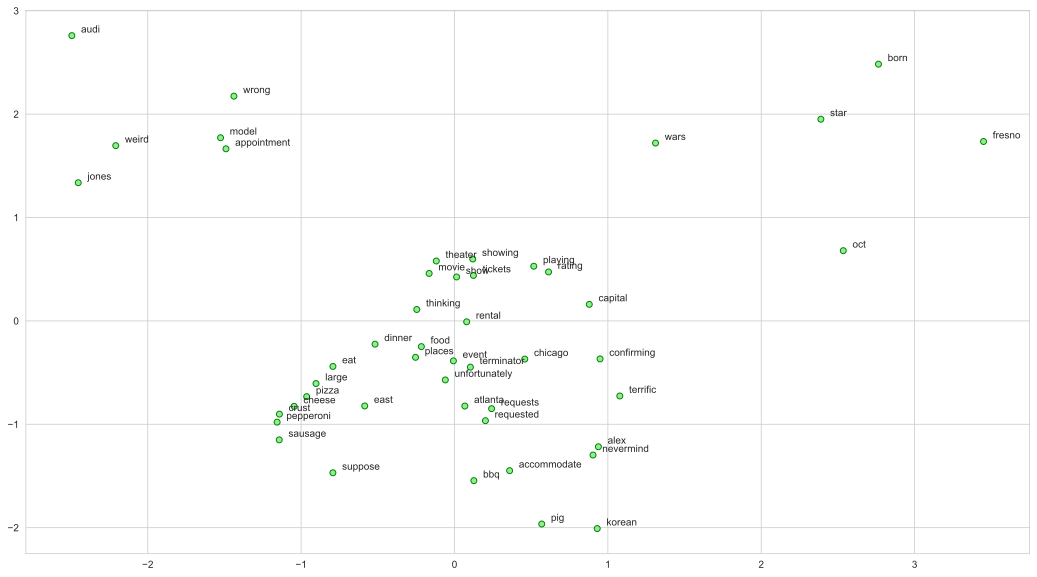

In [55]:
from sklearn.decomposition import PCA

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = ft_model.wv[words]

pca = PCA(n_components=2)
np.set_printoptions(suppress=True)
P = pca.fit_transform(wvs)
labels = words

plt.figure(figsize=(18, 10))
plt.scatter(P[:, 0], P[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, P[:, 0], P[:, 1]):
    plt.annotate(label, xy=(x+0.06, y+0.03), xytext=(0, 0), textcoords='offset points')

In [56]:
ft_model.wv['rental']

array([-0.2456603 , -0.3847549 ,  0.06492562,  0.04740023, -0.05075805,
       -0.22694312,  0.4215116 , -0.33982405, -0.04370858,  0.0629853 ,
       -0.3409566 ,  0.00812502, -0.0774149 ,  0.48186895,  0.21284053,
        0.3371108 , -0.25463784, -0.17870781,  0.18154614, -0.40187714,
       -0.11597514,  0.06976771, -0.2827826 ,  0.34207228,  0.11847469,
        0.09189652,  0.4980718 , -0.389526  , -0.03210843, -0.16801834,
       -0.6243001 ,  0.18326154,  0.2597041 , -0.03512648, -0.03855328,
       -0.23020533, -0.21311814,  0.24731663, -0.12095507,  0.21898097,
       -0.03530402,  0.11089047,  0.38267976, -0.03408687,  0.47464603,
        0.13449542,  0.16546832, -0.0557306 , -0.17744146, -0.08903551,
       -0.1279476 , -0.05045699,  0.1012897 , -0.2515585 , -0.06074018,
        0.3012346 ,  0.2712584 ,  0.00910348, -0.2822897 ,  0.10751042,
        0.1602443 ,  0.05004477, -0.39422616, -0.19322552,  0.03605143,
       -0.2429987 , -0.26940596, -0.05992399, -0.18235217, -0.04

In [57]:
print(ft_model.wv.similarity(w1='pizza', w2='born'))
print(ft_model.wv.similarity(w1='playing', w2='movie'))

0.103287175
0.7937065


In [58]:
st1 = "'tickets movie showing john"
print('Odd one out for [',st1, ']:', ft_model.wv.doesnt_match(st1.split()))

st2 = "pepperoni pizzas cheese pies"
print('Odd one out for [',st2, ']:', ft_model.wv.doesnt_match(st2.split()))

Odd one out for [ 'tickets movie showing john ]: 'tickets
Odd one out for [ pepperoni pizzas cheese pies ]: pies
